In [1]:
import os, pysam, math
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.errors import EmptyDataError     # ← add this import
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
callers = ["Pindel", "Caveman"]

In [4]:
df_TFBS = pd.read_csv("/home/pdutta/GDC_Variant_somatic/Top_TFBS_accuracy.tsv",sep="\t")
df_TFBS

,tags,eval_acc
0,CTCFL,0.983854
1,ZNF426,0.970906
2,SAFB,0.970158
3,RBM34,0.970000
4,TAF15,0.967351
...,...,...
457,GFI1B,0.851123
458,ZNF558,0.851034
459,ZNF19,0.850575
460,SMAD5,0.850318


In [6]:
def log_oods_ratio(p1,p2):
    term1 = math.log2(p1/(1-p1))
    term2 = math.log2(p2/(1-p2))
    return (term1-term2)
def calculate_diff_probab(p1,p2):
    return((p2-p1)*max(p1,p2))

In [14]:
missing_files_log = "missing_prediction_files.txt"
out_dict = {}

with open(missing_files_log, "w") as log_file:
    for caller in callers:
        print(caller)
        dfs = []
        for _, row in df_TFBS.iterrows():
            tfbs = row["tags"][0] if isinstance(row["tags"], list) else row["tags"]
            file_base_path = f"/home/shared/rdavuluri/TCGA_Brain/DANBERT_data/{caller}/{tfbs}/variant_wise"

            if not os.path.exists(file_base_path):
                print(f"⚠︎ Missing folder: {file_base_path}")
                log_file.write(f"Missing folder: {file_base_path}\n")
                continue

            try:
                raw_file = f"{file_base_path}/raw_data.tsv"
                pred_file = f"{file_base_path}/Prediction_result/pred_results.npy"

                if not os.path.exists(raw_file):
                    print(f"⚠︎ Missing file: {raw_file}")
                    log_file.write(f"Missing file: {raw_file}\n")
                    continue
                if not os.path.exists(pred_file):
                    print(f"⚠︎ Missing file: {pred_file}")
                    log_file.write(f"Missing file: {pred_file}\n")
                    continue

                df_temp = pd.read_csv(raw_file, sep="\t")
                prediction_result = np.load(pred_file)

                if 2 * len(df_temp) == len(prediction_result):
                    Reference_probab = prediction_result[::2]
                    Alternative_probab = prediction_result[1::2]
                    df_temp['Ref_probab'] = Reference_probab
                    df_temp['Alt_probab'] = Alternative_probab
                    df_temp['ScoreChange'] = df_temp.apply(
                        lambda row: calculate_diff_probab(row['Ref_probab'], row['Alt_probab']), axis=1
                    )
                    df_temp['LogOddRatio'] = df_temp.apply(
                        lambda row: log_oods_ratio(row['Ref_probab'], row['Alt_probab']), axis=1
                    )
                    df_temp['TFBS'] = tfbs
                else:
                    print(f"⚠︎ Length mismatch: {file_base_path}")
                    log_file.write(f"Length mismatch: {file_base_path}\n")
                    continue

                dfs.append(df_temp)

            except EmptyDataError:
                print(f"⚠︎ Empty file: {raw_file}")
                log_file.write(f"Empty file: {raw_file}\n")
                continue
            except Exception as e:
                print(f"⚠︎ Unexpected error at {file_base_path}: {e}")
                log_file.write(f"Unexpected error at {file_base_path}: {e}\n")
                continue

        out_dict[caller] = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


Pindel_Mutect2-indel
⚠︎ Missing file: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Pindel_Mutect2-indel/KDM4A/variant_wise/Prediction_result/pred_results.npy
Caveman_Mutect2-substitution
⚠︎ Missing folder: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/RBM34/variant_wise
⚠︎ Missing folder: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/SRSF3/variant_wise
⚠︎ Missing file: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/KDM4A/variant_wise/Prediction_result/pred_results.npy
⚠︎ Missing folder: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/NFYA/variant_wise
⚠︎ Missing folder: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/NFYB/variant_wise
⚠︎ Missing folder: /home/shared/rdavuluri/TCGA_Breast/DANBERT_data/cutoff_5/Caveman_Mutect2-substitution/KAT2A/variant_wise
⚠︎ Missing folder: /home/s

In [17]:
base_output_path = "/home/shared/rdavuluri/Brain/Postprocessed_DNABERT"

In [53]:
for caller in callers:
    print(caller)
    out_folder_path = f"{base_output_path}/{caller}"
    if not os.path.exists(out_folder_path):
        os.makedirs(out_folder_path)
    df = out_dict[caller] 
    #display(df)
    df.to_csv(f"{out_folder_path}/all_variant_information.tsv")
    print(df.shape)
    df = df[(df["ref_nucleotide"].str.len() <= 10) & (df["alt_nucleotide"].str.len() <= 10)]
    print(df.groupby(["chr", "variant_start", "variant_end", "ref_nucleotide", "alt_nucleotide"]).ngroups)
    print(df.groupby(['chr','TFBS_start','TFBS_end']).ngroups)

    df_temp = df[(df['Ref_probab'] > 0.5) & (df['Alt_probab'] <= 0.5)]
    df_temp.to_csv(f"{out_folder_path}/disrupted_candidate_variants.tsv", sep="\t", index=False)
    print(f"Number of disrupted candidate variants are {df_temp.shape}")
    print(f"Number of regions are {df_temp.groupby(['chr','TFBS_start','TFBS_end']).ngroups}")
    
    df_temp = df[(df['Ref_probab'] <= 0.5) & (df['Alt_probab'] > 0.5)]
    df_temp.to_csv(f"{out_folder_path}/gained_candidate_variants.tsv", sep="\t", index=False)
    print(f"Number of gained candidate variants are {df_temp.shape}")

Pindel_Mutect2-indel
(718588, 17)
147114
564650
Number of disrupted candidate variants are (3847, 17)
Number of regions are 3585
Number of gained candidate variants are (1788, 17)
Caveman_Mutect2-substitution
(82957, 17)
9452
7997
Number of disrupted candidate variants are (640, 17)
Number of regions are 189
Number of gained candidate variants are (179, 17)


Pindel_Mutect2-indel


/tmp/ipykernel_402354/1039649387.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final_sorted, x="TFBS", y="Count", ax=ax1,
/tmp/ipykernel_402354/1039649387.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_final_sorted["TFBS"], rotation=45, ha="right", fontsize=12)


📸 Saved high-res figure to: Pindel_Mutect2-indel_top_TFBS_variant_vs_accuracy.png
Caveman_Mutect2-substitution


/tmp/ipykernel_402354/1039649387.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final_sorted, x="TFBS", y="Count", ax=ax1,
/tmp/ipykernel_402354/1039649387.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_final_sorted["TFBS"], rotation=45, ha="right", fontsize=12)


📸 Saved high-res figure to: Caveman_Mutect2-substitution_top_TFBS_variant_vs_accuracy.png


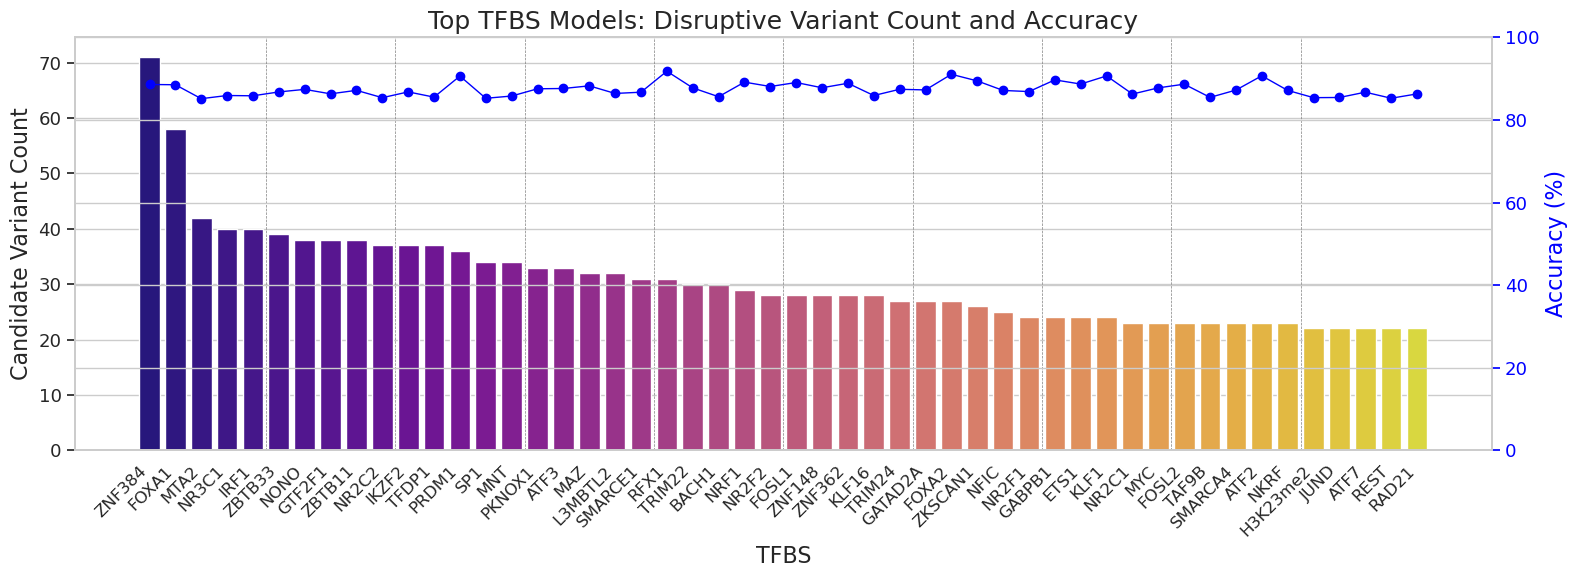

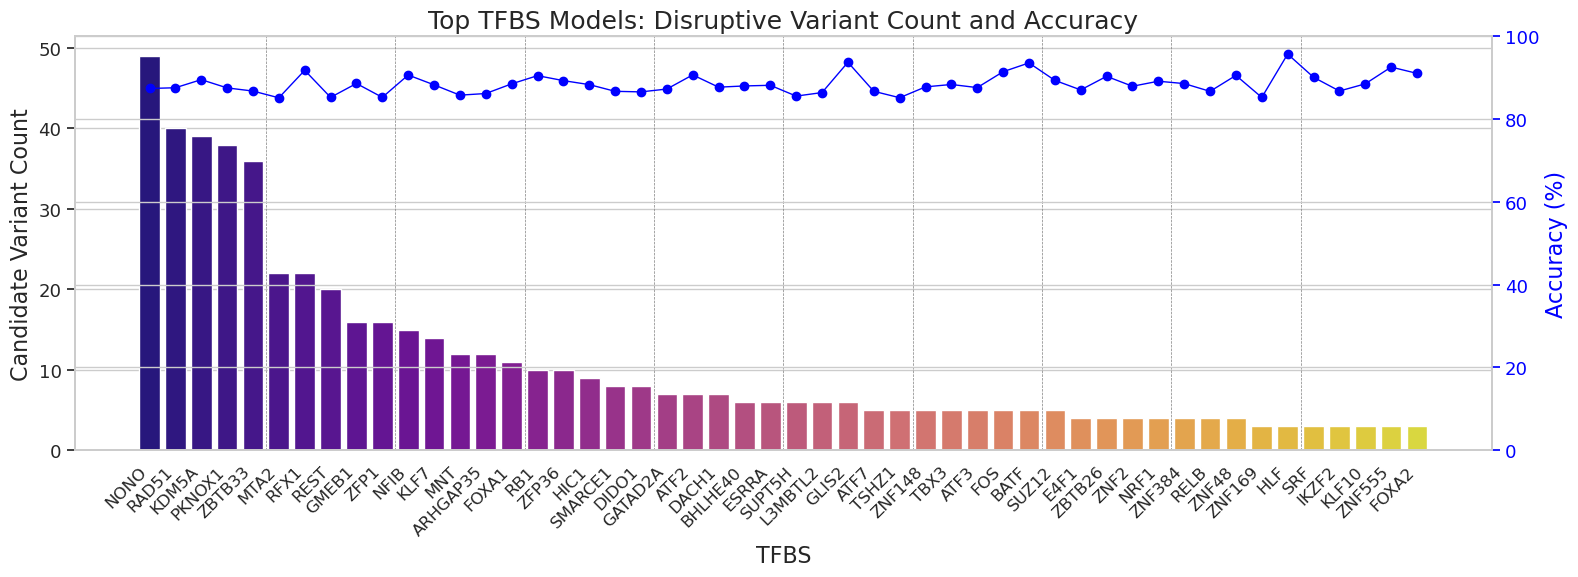

In [44]:
for caller in callers:
    print(caller)
    folder_path = f"{base_output_path}/{threshold}/{caller}"
    df  = pd.read_csv(f"{folder_path}/disrupted_candidate_variants.tsv", sep="\t")
    #display(df_temp)

    # Count occurrences of each TFBS
    tfbs_counts = df["TFBS"].value_counts().head(50).reset_index()
    tfbs_counts.columns = ["TFBS", "Count"]
    df_final = pd.merge(tfbs_counts, df_TFBS, left_on='TFBS', right_on='tags', how='inner')
    # Assuming df_final is already created with 'TFBS', 'Count', and 'eval_acc'
    df_final_sorted = df_final.sort_values('Count', ascending=False).reset_index(drop=True)
    
    # Plot setup
    fig, ax1 = plt.subplots(figsize=(16, 6))
    sns.set(style="whitegrid")
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 14
    })
    
    # Bar plot (left y-axis)
    sns.barplot(data=df_final_sorted, x="TFBS", y="Count", ax=ax1,
            palette=sns.color_palette("plasma", n_colors=len(df_final_sorted)),
            legend=False)
    ax1.set_xlabel("TFBS", fontsize=16)
    ax1.set_ylabel("Candidate Variant Count", fontsize=16)
    ax1.tick_params(axis='y', labelsize=13)
    ax1.set_xticklabels(df_final_sorted["TFBS"], rotation=45, ha="right", fontsize=12)
    
    # Line plot on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df_final_sorted["TFBS"], df_final_sorted["eval_acc"] * 100,
             color="blue", marker="o", linewidth=1, label="Accuracy (%)")
    ax2.set_ylabel("Accuracy (%)", fontsize=16, color="blue")
    ax2.tick_params(axis='y', labelsize=13, colors="blue")
    ax2.set_ylim(0, 100)  # Customize as needed
    
    # Add vertical separators every 5 TFBS
    for i in range(5, len(df_final_sorted), 5):
        ax1.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)
    
    # Title and layout
    plt.title("Top TFBS Models: Disruptive Variant Count and Accuracy", fontsize=18)
    fig.tight_layout()
    fig.show()
    
    # Save high-resolution figure (Nature standard)
    save_path = f"{caller}_top_TFBS_variant_vs_accuracy.png"
    fig.savefig(save_path, dpi=600, bbox_inches='tight')
    print(f"📸 Saved high-res figure to: {save_path}")
    
    # Optional: SVG version for vector graphics
    fig.savefig(f"{caller}_top_TFBS_variant_vs_accuracy.svg", format='svg')